In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm

from sim_biology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
sys.path.append('../../src')
sys.path.append('../../src/adaptive_wavelets')
from losses import get_loss_f
from train import Trainer, Validator
from transform1d import DWT1d
from utils import get_1dfilts
from wave_attributions import Attributer
from visualize import cshow, plot_1dreconstruct, plot_1dfilts

## load data and model

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p)

In [119]:
# get image
data = iter(test_loader).next()[0].to(device)

# wavelet transform 
wt = DWT1d(wave='db5', mode='symmetric', J=5, init_factor=1, noise_factor=0.0).to(device)

data_t = wt(data)
recon = wt.inverse(data_t)

In [185]:
import acd
from acd.scores import cd_propagate
from scipy.special import expit as sigmoid
from torch import tanh
import math
sys.path.append('../../lib/trim')
from trim import TrimModel

mt = TrimModel(model, wt.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

In [180]:
blobs = []
idx = 0
for i in range(len(data_t)):
    blob = torch.zeros_like(data_t[i])
    if i==idx:
        blob[:,:,0] = 1
    blobs.append(blob)
blobs = tuple(blobs)

def tuple_mul(a, b):
    n = len(a)
    c = []
    for i in range(n):
        c.append(torch.mul(a[i], b[i]))
    return tuple(c)

In [181]:
a = wt.inverse(tuple_mul(data_t, blobs))

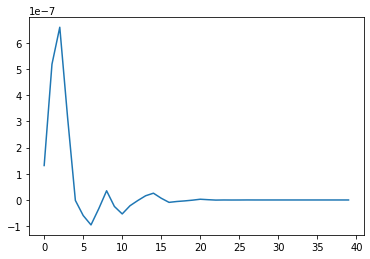

In [182]:
plt.plot(a[2].squeeze().detach().cpu())

In [188]:
for i in range(6):
    print(data_t[i].shape)

torch.Size([100, 1, 9])
torch.Size([100, 1, 24])
torch.Size([100, 1, 16])
torch.Size([100, 1, 12])
torch.Size([100, 1, 10])
torch.Size([100, 1, 9])


In [189]:
rel_h, irrel_h = cd_propagate.propagate_lstm(recon, model.model.lstm, 0, 1, 'cuda')
rel, irrel = cd_propagate.propagate_conv_linear(rel_h, irrel_h, model.model.fc)

In [190]:
rel

tensor([[[ 5.4672e-03]],

        [[ 6.8821e-02]],

        [[ 2.1360e-02]],

        [[ 3.4667e-02]],

        [[ 3.3291e-02]],

        [[-3.3587e-03]],

        [[ 4.5960e-03]],

        [[ 4.2683e-03]],

        [[-3.5828e-02]],

        [[ 3.2311e-02]],

        [[-3.7483e-05]],

        [[ 4.3141e-03]],

        [[ 2.1480e-04]],

        [[ 3.4262e-02]],

        [[ 3.1088e-02]],

        [[ 1.2598e-03]],

        [[ 8.6132e-03]],

        [[ 7.8547e-03]],

        [[ 6.9120e-02]],

        [[ 2.0238e-02]],

        [[ 7.9555e-03]],

        [[-2.8978e-04]],

        [[-4.1782e-02]],

        [[-4.1099e-02]],

        [[ 3.8711e-02]],

        [[ 3.2314e-04]],

        [[ 2.9553e-03]],

        [[ 4.9533e-02]],

        [[ 1.4921e-03]],

        [[ 7.9564e-03]],

        [[ 2.1789e-04]],

        [[-1.9134e-02]],

        [[-1.6621e-02]],

        [[ 2.6966e-02]],

        [[ 4.3126e-02]],

        [[-5.2926e-03]],

        [[-3.8052e-03]],

        [[ 7.9021e-03]],

        [[-2

In [ ]:
# T = 40
# DIV = 40
# track_segs_fourty = [(math.floor(s * T / DIV), math.floor((s+1) * T / DIV))
#                     for s in range(DIV)]
# [interpret.calc_cd_score(xtrack_t, None, s, e, dnn.model)
#                   for (s, e) in track_segs_fourty]